# Load Dependencies

In [1]:
import glob
from script.utils import *

# Load Data

In [2]:
data_dir = './Data/data_cc/'
rundata_dir = './Data/rundata_cc/'
df=pd.read_csv(data_dir+"experiment_index.csv")
ele_smi=df['Electrophile_SMILES'].tolist()
nuc_smi=df['Nucleophile_SMILES'].tolist()
lig_smi=df['Ligand_SMILES'].tolist()
base_smi=df['Base_SMILES'].tolist()
sol_smi=df['Solvent_SMILES'].tolist()

In [3]:
target = 'yield'
defined_chemical_space = {'Electrophile_SMILES':list(set(ele_smi)), 
                          'Nucleophile_SMILES':list(set(nuc_smi)), 
                          'Ligand_SMILES':list(set(lig_smi)),
                          'Base_SMILES':list(set(base_smi)), 
                          'Solvent_SMILES':list(set(sol_smi))
                          }
domain = get_domain(defined_chemical_space)
print('The size of chemical space is: %d'%len(domain))

The size of chemical space is: 3696


# Generate Descriptor

In [10]:
desc_map={}
for i in glob.glob(data_dir+'*.csv'):
    if i.split('/')[-1].split('.')[0].split('_')[-1]=='dft':    
        tem_data=np.array(pd.read_csv(i))
        for j in range(len(tem_data)):
            desc_map[tem_data[j][0]]=tem_data[j][1:]
tem_data=np.array(pd.read_csv('./Data/data_cc/ligand-conformers_dft.csv'))
for i in range(len(tem_data)):
    desc_map[tem_data[i][0]]=tem_data[i][1:]
desc_domain = getdescdomain(domain,desc_map,defined_chemical_space)

# Reaction Optimization

In [6]:
tem_batch_size=5
ten_cc1=3
ten_cc2=2
ten_cc3=1
tem_cc1num=100
tem_cc2num=50
tem_cc2num=5
model='rf'
all_recorded_max = []
all_recorded_over_eighty = []
all_recorded_over_ninty = []
results_all_cycle=[]
for cycle in range(50):
    print(cycle)
    recorded_max = []
    recorded_over_eighty = []
    recorded_over_ninty = []
    np.random.seed(None)
    result = pd.DataFrame.from_dict({tmp_key:[] for tmp_key in list(defined_chemical_space.keys()) + [target]})
    init_react = random_recom(tem_batch_size,domain,desc_domain,'./Data/rundata_cc/recommend/init.csv',random_state=None)
    init_target = exe_exp_3(init_react,result_pth=data_dir+'experiment_index.csv')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        init_react[target] = init_target
    init_react.to_csv(rundata_dir+'result_ourwork/result.csv')
    result = add_result(result,rundata_dir+'result_ourwork/result.csv')
    max_target = result[target].max()
    over_eighty = np.where(result[target].to_numpy()>80)[0].shape[0]/len(result)
    over_ninty = np.where(result[target].to_numpy()>90)[0].shape[0]/len(result)
    recorded_max.append(max_target)
    recorded_over_eighty.append(over_eighty)
    recorded_over_ninty.append(over_ninty)

    #print('Initial, target maximum value: %.4f, rate of target over 0.8: %.4f, rate of target over 0.9: %.4f'%(max_target,over_eighty,over_ninty))
    train_x,train_y = result2xy(desc_domain,result=result)
    tpk = Top_k(train_x,train_y,n_jobs=8,model=model)
    domain_sampled = tpk.recommend(domain,desc_domain,result,batch_size=tem_batch_size,target = 'yield')
    stage=1
    all_stage=[1]

    for try_idx in range(1,10):
        domain_sampled.to_csv(rundata_dir+'recommend_topk/cycle_%d.csv'%try_idx)
        new_target = exe_exp_3(domain_sampled,result_pth=data_dir+'experiment_index.csv')
        new_result = deepcopy(domain_sampled)
        new_result[target] = new_target
        new_result.to_csv(rundata_dir+'result_ourwork/cycle_%d.csv'%try_idx)
        result = add_result(result,rundata_dir+'result_ourwork/cycle_%d.csv'%try_idx)
        max_target = result[target].max()
        over_eighty = np.where(result[target].to_numpy()>80)[0].shape[0]/len(result)
        over_ninty = np.where(result[target].to_numpy()>90)[0].shape[0]/len(result)
        recorded_max.append(max_target)
        recorded_over_eighty.append(over_eighty)
        recorded_over_ninty.append(over_ninty)
        #print('Round %d, Cycle %d, target maximum value: %.4f, rate of target over 0.8: %.4f, rate of target over 0.9: %.4f'%(cycle,try_idx,max_target,over_eighty,over_ninty))
        train_x,train_y = result2xy(desc_domain,result=result)
        tpk = Top_k_add_or_total(train_x,train_y,n_jobs=8,model=model)
        domain_sampled,stage = tpk.recommend(domain,desc_domain,result,batch_size=tem_batch_size,\
                stage=stage,cc1=ten_cc1,cc2=ten_cc2,cc1_num=tem_cc1num,cc2_num=tem_cc2num,target = 'yield')
        all_stage.append(stage)
        stage=max(all_stage)
    results_all_cycle.append(result[target].tolist()[:50])
    all_recorded_max.append(recorded_max)
    all_recorded_over_eighty.append(recorded_over_eighty)
    all_recorded_over_ninty.append(recorded_over_ninty)
    np.save(rundata_dir+'datacctotal_ourwork_dft.npy',results_all_cycle)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


# Results

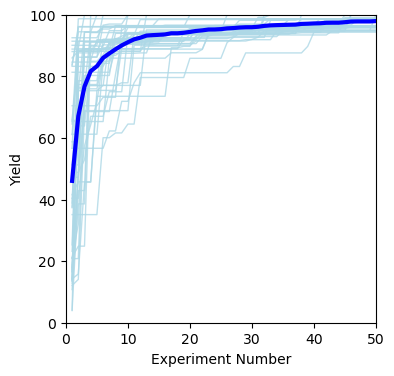

In [7]:
plt.figure(figsize=(4,4))
results_all_cycle=np.load(rundata_dir+'ourwork_results_totalcn_batch_%d_cc_%d_cc_%d_cc1num_%d_cc2num_%d_%s.npy'%\
                                                (tem_batch_size,ten_cc1,ten_cc2,tem_cc1num,tem_cc2num,model),allow_pickle=True)
all_max100,_,_,_,_=get_all_max100(results_all_cycle)
recorded_max_mean1=plot_figure(all_max100,c1='lightblue',c2='blue',title='')